In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings
import pickle
from mpl_toolkits.basemap import Basemap
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
matplotlib.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Read Data

filepath = '/Users/kevinzhao/Kaggle/Recruit_Restaurant/inputs/'

air_reserve = pd.read_csv(filepath + 'air_reserve.csv')
hpg_reserve = pd.read_csv(filepath + 'hpg_reserve.csv')
air_store_info = pd.read_csv(filepath + 'air_store_info.csv')
hpg_store_info = pd.read_csv(filepath + 'hpg_store_info.csv')

store_id_relation = pd.read_csv(filepath + 'store_id_relation.csv')

In [3]:
air_data_full = pickle.load(open('air_data_full.p', 'rb'))

In [4]:
air_data_full.head()

,air_store_id,hpg_store_id,visit_datetime,reserve_datetime,air_reserve_visitors,hpg_reserve_visitors,air_genre_name,hpg_genre_name,air_area_name,latitude,longitude,visit_year,visit_month,visit_day,reserve_year,reserve_month,reserve_day,visit_hour,reserve_hour
0,air_877f79706adbfb06,NaN,2016-01-01 19:00:00,2016-01-01 16:00:00,1,1,Japanese food,NaN,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016,1,1,2016,1,1,19,16
1,air_db4b38ebe7a7ceff,hpg_bcecaa70222d94e5,2016-01-01 19:00:00,2016-01-01 19:00:00,3,3,Dining bar,NaN,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,2016,1,1,2016,1,1,19,19
2,air_db4b38ebe7a7ceff,hpg_bcecaa70222d94e5,2016-01-01 19:00:00,2016-01-01 19:00:00,6,6,Dining bar,NaN,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,2016,1,1,2016,1,1,19,19
3,air_877f79706adbfb06,NaN,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2,Japanese food,NaN,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016,1,1,2016,1,1,20,16
4,air_db80363d35f10926,hpg_878cc70b1abc76f7,2016-01-01 20:00:00,2016-01-01 01:00:00,5,5,Dining bar,NaN,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,2016,1,1,2016,1,1,20,1


## Check for missing values

Let's start with the store IDs, datetime, and reservations

In [5]:
air_data_full.visit_datetime.isnull().value_counts()

False    92427
Name: visit_datetime, dtype: int64

In [6]:
air_data_full.reserve_datetime.isnull().value_counts()

False    92427
Name: reserve_datetime, dtype: int64

In [8]:
air_data_full.air_reserve_visitors.isnull().value_counts()

False    92427
Name: air_reserve_visitors, dtype: int64

In [10]:
air_data_full.hpg_reserve_visitors.isnull().value_counts()

False    92427
Name: hpg_reserve_visitors, dtype: int64

In [11]:
air_data_full.air_store_id.isnull().value_counts()

False    92427
Name: air_store_id, dtype: int64

In [12]:
air_data_full.hpg_store_id.isnull().value_counts()

True     56114
False    36313
Name: hpg_store_id, dtype: int64

Looks like a lot of them are missing...let's check if any have no store id at all

In [13]:
air_data_full.apply(
    lambda row: 1 if (type(row.air_store_id)!=str and type(row.hpg_store_id)!=str) else 0, axis=1).value_counts()

0    92427
dtype: int64

Cool...so every restaurant has air_store_id, hpg_store_id, or both.

Now, let's take a look at the other columns.

In [14]:
air_data_full.visit_datetime.isnull().value_counts()

False    92427
Name: visit_datetime, dtype: int64

In [15]:
air_data_full.reserve_datetime.isnull().value_counts()

False    92427
Name: reserve_datetime, dtype: int64

In [18]:
air_data_full.air_genre_name.isnull().value_counts()

False    92427
Name: air_genre_name, dtype: int64

In [19]:
air_data_full.air_area_name.isnull().value_counts()

False    92427
Name: air_area_name, dtype: int64

In [20]:
air_data_full.latitude.isnull().value_counts()

False    92427
Name: latitude, dtype: int64

Every row has a visit and reserve datetime. Rows missing with missing features are missing all of genre_name, area_name, latitude, longitude. More than half of the rows are missing these features, so we will have to impute or do something about them.

## Restaurant locations

Visualize the location of each restaurant

In [21]:
def draw_map(df, title):
    plt.figure(figsize=(11,6))
    map = Basemap(resolution='i',llcrnrlon=127, urcrnrlon=147,
                  llcrnrlat=29, urcrnrlat=47, lat_0=0, lon_0=0,)
    map.shadedrelief()
    map.drawcoastlines()
    map.drawcountries(linewidth = 3)
    map.drawstates(color='0.3')
    parallels = np.arange(0.,360,10.,)
    map.drawparallels(parallels, labels = [True for s in range(len(parallels))])
    meridians = np.arange(0.,360,10.,)
    map.drawmeridians(meridians, labels = [True for s in range(len(meridians))])
    #______________________
    # put restaurants on map
    for index, (y,x) in df[['latitude','longitude']].iterrows():
        x, y = map(x, y)
        map.plot(x, y, marker='o', markersize = 5, markeredgewidth = 1, color = 'red',
                 markeredgecolor='k')
    plt.title(title, y = 1.05)

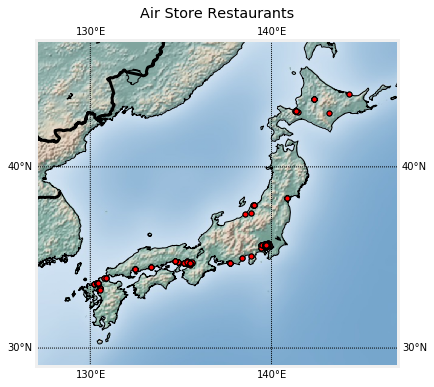

In [22]:
draw_map(air_store_info, 'Air Store Restaurants')

It looks like the restaurants are spread throughout the entire country. We can try pinpointing the exact island (of the main four) each restaurant is located.

## Check genre names

Find similar genres and other related features

In [31]:
air_data_full.genre_name.str.contains('Japanese').value_counts()

False    605522
True     356093
Name: genre_name, dtype: int64

In [18]:
air_data_full.genre_name.value_counts()

Japanese style                  305861
International cuisine           124118
Grilled meat                     73385
Creation                         70074
Italian                          61471
Seafood                          56030
Spain Bar/Italian Bar            49044
Izakaya                          32503
Italian/French                   21121
Japanese food in general         17559
Shabu-shabu/Sukiyaki             14679
Chinese general                  12753
Creative Japanese food           11965
Okonomiyaki/Monja/Teppanyaki     11311
Korean cuisine                   10859
Japanese cuisine/Kaiseki         10687
Japanese food                    10021
Karaoke                           8873
Dining bar                        8249
French                            7046
Yakiniku/Korean food              6948
Steak/Hamburger/Curry             6550
Western food                      5539
Cafe                              4413
Bistro                            4181
Cafe/Sweets              

In [48]:
air_data_full.genre_name.unique()

array(['Japanese food', 'Dining bar', 'Izakaya',
       'Okonomiyaki/Monja/Teppanyaki', 'Italian/French', 'Cafe/Sweets',
       'Yakiniku/Korean food', 'Western food', 'Bar/Cocktail', 'Other',
       'Creative cuisine', 'Karaoke/Party', 'International cuisine',
       'Asian', nan, 'French', 'Japanese style', 'Seafood',
       'Japanese food in general', 'Creation', 'Grilled meat',
       'Spain Bar/Italian Bar', 'Italian', 'Shabu-shabu/Sukiyaki',
       'Japanese cuisine/Kaiseki', 'Bistro', 'Steak/Hamburger/Curry',
       'Chinese general', 'Creative Japanese food', 'Korean cuisine',
       'Sushi', 'Udon/Soba', 'Sweets', 'Karaoke', 'Cafe',
       'Thai/Vietnamese food', 'Pasta/Pizza', 'Party', 'Amusement bar',
       'Cantonese food', 'Shanghai food', 'Sichuan food',
       'Spain/Mediterranean cuisine', 'Dim Sum/Dumplings',
       'Taiwanese/Hong Kong cuisine'], dtype=object)

## Check area names

In [49]:
air_data_full.area_name.value_counts()

Tōkyō-to Shinjuku-ku None                      47264
Hyōgo-ken Kōbe-shi None                        35597
Osaka Prefecture Osaka None                    35153
Tōkyō-to Chūō-ku Ginza                         34851
Ōsaka-fu Ōsaka-shi Shinsaibashisuji            33679
Hiroshima-ken Hiroshima-shi Hondōri            30369
Tōkyō-to Toshima-ku None                       26257
Tōkyō-to Hachiōji-shi Ishikawamachi            23592
Tōkyō-to Shibuya-ku None                       23571
Hokkaidō Sapporo-shi Minami 4 Jōnishi          22293
Tōkyō-to Taitō-ku None                         19807
Fukuoka-ken Fukuoka-shi None                   19723
Hokkaidō Sapporo-shi None                      18729
Tōkyō-to Minato-ku Takanawa                    17784
Shizuoka-ken Hamamatsu-shi Sukenobuchō         17376
Fukuoka-ken Fukuoka-shi Daimyō                 16953
Shizuoka-ken Shizuoka-shi Hinodechō            16600
Fukuoka-ken Fukuoka-shi Hakata Ekimae          16086
Fukuoka-ken Kitakyūshū-shi Sunatsu            

In [50]:
air_data_full.area_name.unique()

array(['Tōkyō-to Minato-ku Shibakōen', 'Ōsaka-fu Ōsaka-shi Shinmachi',
       'Hokkaidō Asahikawa-shi 6 Jōdōri',
       'Miyagi-ken Sendai-shi Kamisugi',
       'Hiroshima-ken Hiroshima-shi Kokutaijimachi',
       'Shizuoka-ken Hamamatsu-shi Motoshirochō',
       'Fukuoka-ken Kurume-shi Jōnanmachi',
       'Hokkaidō Sapporo-shi Minami 3 Jōnishi',
       'Shizuoka-ken Shizuoka-shi Ōtemachi',
       'Fukuoka-ken Fukuoka-shi Daimyō',
       'Fukuoka-ken Kitakyūshū-shi Ōtemachi',
       'Hyōgo-ken Nishinomiya-shi Rokutanjichō',
       'Hokkaidō Abashiri-shi Minami 6 Jōhigashi',
       'Fukuoka-ken Fukuoka-shi Hakata Ekimae',
       'Tōkyō-to Chūō-ku Tsukiji', 'Tōkyō-to Shibuya-ku Shibuya',
       'Fukuoka-ken Kitakyūshū-shi None', 'Tōkyō-to Itabashi-ku Itabashi',
       'Tōkyō-to Taitō-ku Higashiueno', 'Ōsaka-fu Ōsaka-shi Kyūtarōmachi',
       'Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike',
       'Tōkyō-to Chūō-ku Ginza',
       'Hiroshima-ken Fukuyama-shi Higashisakuramachi',
       'Nii

Should clean the data and make the ō easier to type